<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Unit_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Import needed stuff
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [14]:
url_basket = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
basket_data = pd.read_csv(url_basket)

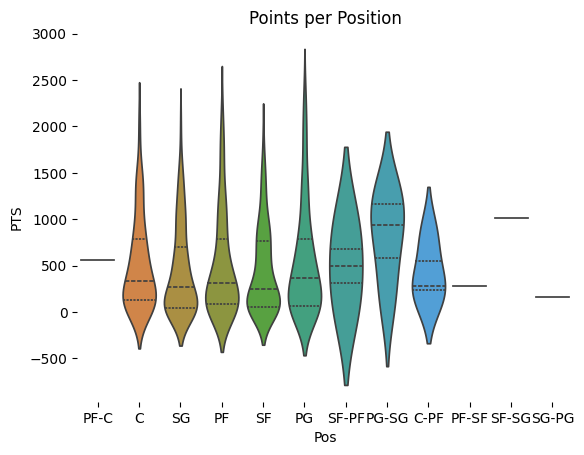

In [8]:
sns.violinplot(data=basket_data, x='Pos', y='PTS', inner='quart', hue='Pos')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.title('Points per Position')
plt.show()

shows how basketball players' points (PTS) are distributed across different positions (Pos). The plot helps me see not just the average points, but also how spread out the points are for each position, including key details like any outliers

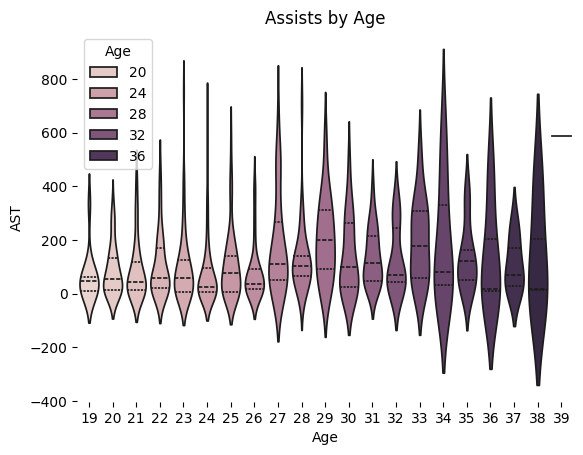

In [10]:
sns.violinplot(data=basket_data, x='Age', y='AST', inner='quart', hue='Age')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.title('Assists by Age')
plt.show()

The plot helps understand how the number of assists varies by age group, displaying not just the average number of assists but also the spread and range of values.

In [16]:
diff_pts_minus_ast = basket_data['PTS'] - basket_data['AST']
# Adds a new column 'diff_pts_minus_ast' to the DataFrame
basket_data.insert(loc=5, column='diff_pts_minus_ast', value=diff_pts_minus_ast)

creates a new column in the basket_data DataFrame which calculates the difference between each player's points (PTS) and assists (AST) and allows me to compare how much more a player scores than they assist, or vice versa, by looking at the values in the new column.

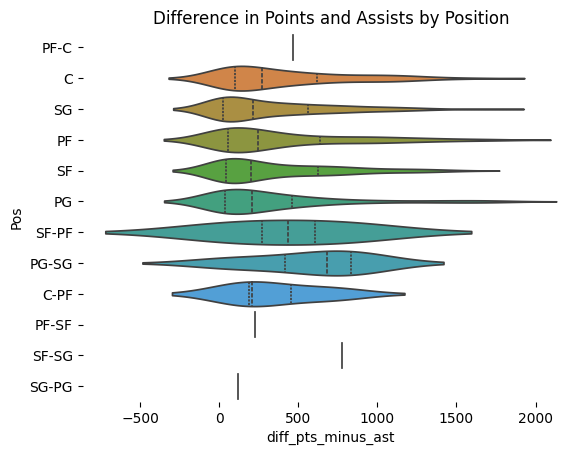

In [17]:
sns.violinplot(data=basket_data, x='diff_pts_minus_ast', y='Pos', inner='quart', hue='Pos')
sns.despine(top=True, right=True, bottom=True, left=True)  # removes border box in plot
plt.title('Difference in Points and Assists by Position')
plt.show()

creates a violin plot to show the distribution of the difference between points (PTS) and assists (AST) for each basketball position (Pos). The goal is to compare how the difference between scoring and playmaking varies across different positions in basketball.

In [18]:
position_encode = pd.Categorical(basket_data['Pos'])
print(position_encode)

['PF-C', 'C', 'SG', 'PF', 'SG', ..., 'PF', 'PG', 'C', 'C', 'C']
Length: 572
Categories (12, object): ['C', 'C-PF', 'PF', 'PF-C', ..., 'SF-PF', 'SF-SG', 'SG', 'SG-PG']


In [19]:
pos_encode = pd.Categorical(basket_data['Pos'])
pos_idx = pos_encode.codes

In [20]:
pos_coords = {"Pos": pos_encode.categories}
pos_coords

{'Pos': Index(['C', 'C-PF', 'PF', 'PF-C', 'PF-SF', 'PG', 'PG-SG', 'SF', 'SF-PF',
        'SF-SG', 'SG', 'SG-PG'],
       dtype='object')}

In [22]:
with pm.Model(coords=pos_coords) as trb_pos_model:
    # Priors: set a normal distribution for the mean and a half-normal for the standard deviation
    μ = pm.Normal('μ', mu=0, sigma=10, dims="Pos")
    σ = pm.HalfNormal('σ', sigma=10, dims="Pos")

    # The idx variable tells the model which diffs belong to the same position and makes model generate a posterior for each position
    y = pm.Normal('y',
                  mu=μ[pos_idx],  # The mean for each player position
                  sigma=σ[pos_idx],
                  observed=basket_data['TRB'])  # Observed values are the Total Rebounds (TRB)

    idata_trb_pos_model = pm.sample()


Output()

Output()

defines priors for the mean and standard deviation of rebounds for each position, assuming the means follow a normal distribution and the standard deviations follow a half-normal distribution. then compares the observed rebound data. it generates posterior distributions for the parameters, which can be used to make predictions about rebounds by position.

In [23]:
pos_encode = pd.Categorical(basket_data['Pos'])
pos_idx = pos_encode.codes

In [24]:
pos_coords = {"Pos": pos_encode.categories}


Output()

Output()

ERROR:pymc.stats.convergence:There were 596 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


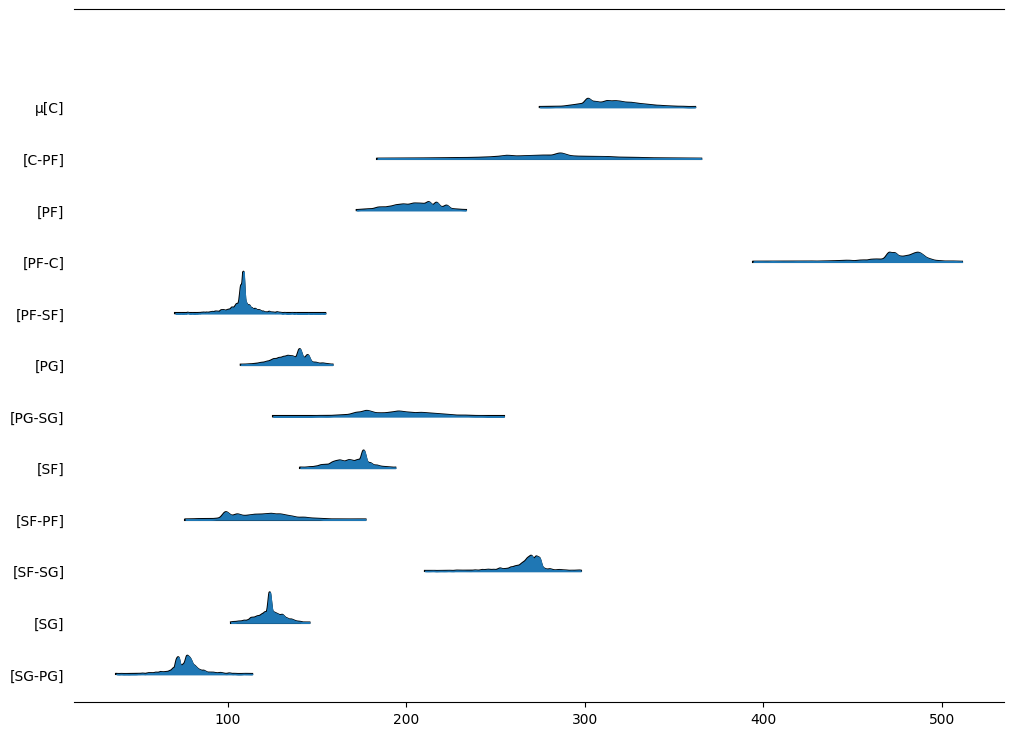

In [25]:
with pm.Model(coords=pos_coords) as trb_pos_model_h:
    # Hyperpriors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)  # Prior for the mean of all positions
    μ_sd = pm.HalfNormal('μ_sd', sigma=10)  # Prior for the standard deviation of all positions

    # Priors for each player position mean and standard deviation
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="Pos")
    σ = pm.HalfNormal('σ', sigma=10, dims="Pos")

    # Likelihood, The model will predict TRB based on player position
    y = pm.Normal('y', mu=μ[pos_idx], sigma=σ[pos_idx], observed=basket_data['TRB'])

    # Sampling
    idata_trb_pos_model_h = pm.sample()

# Plotting the posterior distributions for the mean for each player position
axes = az.plot_forest(idata_trb_pos_model_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

defines priors for the overall mean and standard deviation for all positions. then sets up position-specific priors for the mean (μ) and standard deviation (σ) using the hyperpriors. uses these priors to predict rebounds based on player position and then I plot the posterior distributions of the mean rebounds for each position, focusing on the middle 99.7% of the values (the credible interval)

In [26]:
pos_encode = pd.Categorical(basket_data['Pos'])
pos_idx = pos_encode.codes

In [27]:
pos_coords = {"Pos": pos_encode.categories}


Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 453 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


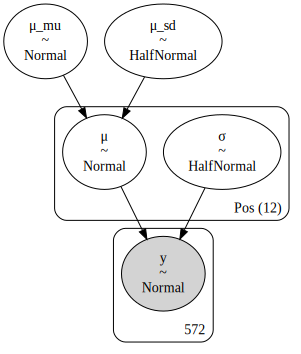

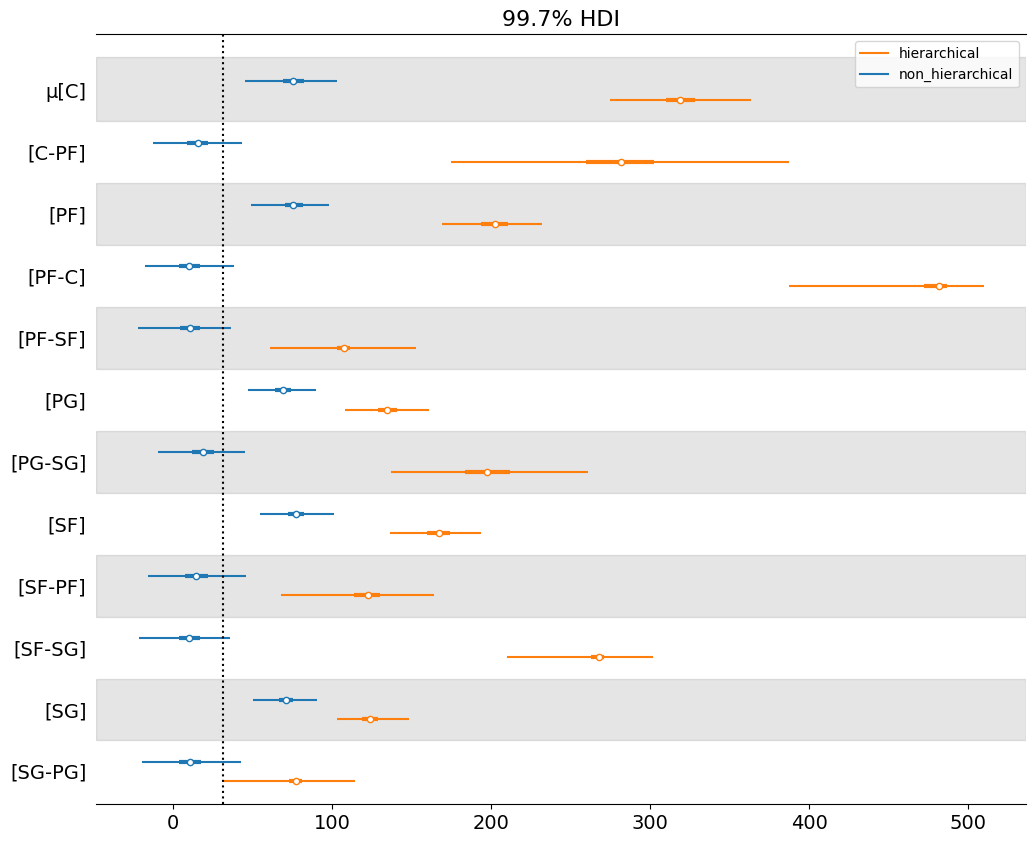

In [28]:
with pm.Model(coords=pos_coords) as trb_pos_model_nh:
    # Priors for non-hierarchical model
    μ = pm.Normal('μ', mu=0, sigma=10, dims="Pos")
    σ = pm.HalfNormal('σ', sigma=10, dims="Pos")

    # Likelihood, Rebounds (TRB) based on player position
    y = pm.Normal('y', mu=μ[pos_idx], sigma=σ[pos_idx], observed=basket_data['TRB'])

    # Sampling from the posterior distribution
    idata_trb_pos_model_nh = pm.sample()

# Hierarchical Model
with pm.Model(coords=pos_coords) as trb_pos_model_h:
    # Hyperpriors for hierarchical model
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', sigma=10)

    # Priors for each player position μ and σ
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="Pos")
    σ = pm.HalfNormal('σ', sigma=10, dims="Pos")

    # Likelihood: Rebounds (TRB) based on player position
    y = pm.Normal('y', mu=μ[pos_idx], sigma=σ[pos_idx], observed=basket_data['TRB'])

    idata_trb_pos_model_h = pm.sample()

axes = az.plot_forest([idata_trb_pos_model_nh, idata_trb_pos_model_h], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10), hdi_prob=0.997)

# Plotting the overall mean of the hierarchical model (μ_mu) to show the global mean of the priors
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_trb_pos_model_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":")

# Visualize the model graphs for both models
pm.model_to_graphviz(trb_pos_model_nh)  # Non-hierarchical model graph
pm.model_to_graphviz(trb_pos_model_h)   # Hierarchical model graph

I compared two Bayesian models for analyzing TRB by player position: one non-hierarchical and one hierarchical. In the non-hierarchical model, each position has its own separate average and standard deviation for rebounds. In the hierarchical model, the positions share some common information through hyperpriors, which help improve the estimates by relating the positions to each other. Both models predict rebounds based on position. The plot shows the 99.7% range of the posterior distributions for the average rebounds per position for both models